# Kerninghan - Lin Algorithm for VLSI CAD Partitioning

## For two equal partitions P1 and P2

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
    
    def addNode(self, node, affiliation):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost

    def IE(self, node):
        #(internal, external) cost of nodes
        internal, external = 0, 0
        d = self.node_affiliation
        p = d[node]
        for i in self.adj_list:
            if(i[0] == node):
                if(d[i[1]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            elif(i[1] == node):
                if(d[i[0]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            else:
                pass
        return (internal, external)

class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p1 = [i for i in nodes if self.graph.node_affiliation[i] == 'p1']
        colors = ['red' if n in p1 else 'green' for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        plt.show()

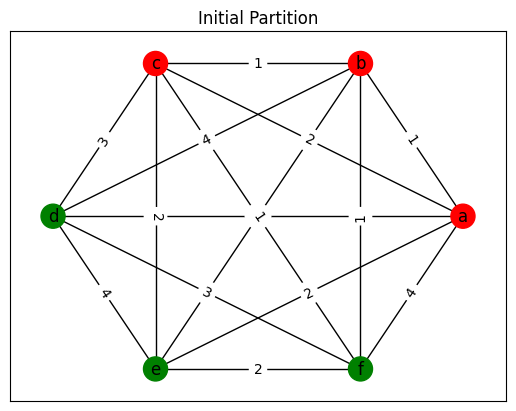

The wire cost of partitioning is 22


In [2]:
graph = Graph()

# equitable distribution

graph.addNode('a', 'p1')
graph.addNode('b', 'p1')
graph.addNode('c', 'p1')
graph.addNode('d', 'p2')
graph.addNode('e', 'p2')
graph.addNode('f', 'p2')

graph.addEdge('a','f', 4)
graph.addEdge('a','e', 2)
graph.addEdge('a','d', 3)
graph.addEdge('a','b', 1)
graph.addEdge('a','c', 2)
graph.addEdge('b','c', 1)
graph.addEdge('b','d', 4)
graph.addEdge('b','e', 2)
graph.addEdge('b','f', 1)
graph.addEdge('c','d', 3)
graph.addEdge('c','e', 2)
graph.addEdge('c','f', 1)
graph.addEdge('d','e', 4)
graph.addEdge('d','f', 3)
graph.addEdge('e','f', 2)

gv = GraphVisualizer()
gv.addEdges(graph)
gv.visualize("Initial Partition")

print("The wire cost of partitioning is",graph.get_cost())

In [3]:
def kerninghan_lin(graph):
    nodes = graph.nodes
    increments = []
    prefix = [0]
    swaps = []
    swapped = {}
    d = graph.node_affiliation

    sort_str = lambda x: ''.join(sorted(x))
    for i in nodes:
        swapped[i] = False
    
    n = len(nodes)//2
    first = True

    I, E, D = {},{},{}
    
    for i in range(n):
        newnodes = [i for i in nodes if not swapped[i]]
        p1 = [i for i in newnodes if graph.node_affiliation[i] == 'p1']
        p2 = [i for i in newnodes if i not in p1]
        p1.sort()
        p2.sort()
        
        G = {}
        for i in newnodes:
            if first:
                I[i],E[i] = graph.IE(i)
                D[i] = E[i] - I[i]
            else:
                x = swaps[len(swaps) - 1]
                s1,s2 = sort_str(i+x[0]), sort_str(i+x[1])
                if(d[x[0]] == d[i]):
                    D[i] = D[i] + (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
                else:
                    D[i] = D[i] - (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
        if first:
            first = False
        
        for i in p1:
            for j in p2:
                G[i+j] = D[i] + D[j] - 2*graph.cxy.get(i+j, 0)
        
        swap = max(G, key=G.get)
        increments.append(G[swap])
        swaps.append(swap)

        swapped[swap[0]] = True
        swapped[swap[1]] = True
    
    for i in range(len(increments)):
        prefix.append(increments[i] + prefix[i])
    
    maxim_ind = np.argmax(prefix)
    return (swaps, maxim_ind-1)

In [4]:
swaps,m = kerninghan_lin(graph)

### Visualizing the Kerninghan Lin Algorithm every swap step

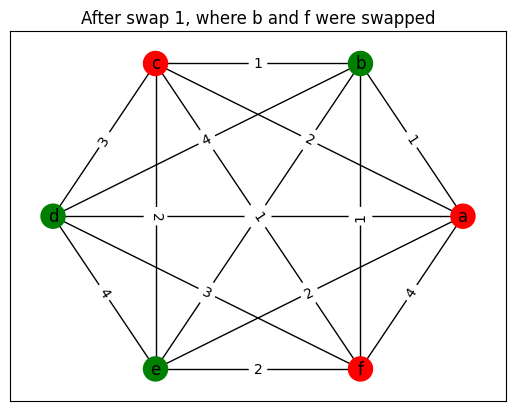

The wire cost of partitioning is 18


In [5]:
k = 0
while(k <= m):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    gv = GraphVisualizer()
    gv.addEdges(graph)
    gv.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The wire cost of partitioning is",graph.get_cost())
    k += 1

### Thus we see that by applying KL algorithm here, we see the cost of partitioning decreases by 4 units

#### What if we hadn't stopped at index (`m`) ?

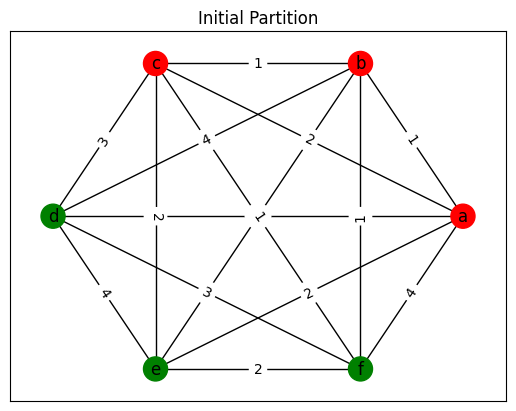

The wire cost of partitioning is 22


In [6]:
graph = Graph()
graph.addNode('a', 'p1')
graph.addNode('b', 'p1')
graph.addNode('c', 'p1')
graph.addNode('d', 'p2')
graph.addNode('e', 'p2')
graph.addNode('f', 'p2')

graph.addEdge('a','f', 4)
graph.addEdge('a','e', 2)
graph.addEdge('a','d', 3)
graph.addEdge('a','b', 1)
graph.addEdge('a','c', 2)
graph.addEdge('b','c', 1)
graph.addEdge('b','d', 4)
graph.addEdge('b','e', 2)
graph.addEdge('b','f', 1)
graph.addEdge('c','d', 3)
graph.addEdge('c','e', 2)
graph.addEdge('c','f', 1)
graph.addEdge('d','e', 4)
graph.addEdge('d','f', 3)
graph.addEdge('e','f', 2)

gv = GraphVisualizer()
gv.addEdges(graph)
gv.visualize("Initial Partition")
print("The wire cost of partitioning is",graph.get_cost())

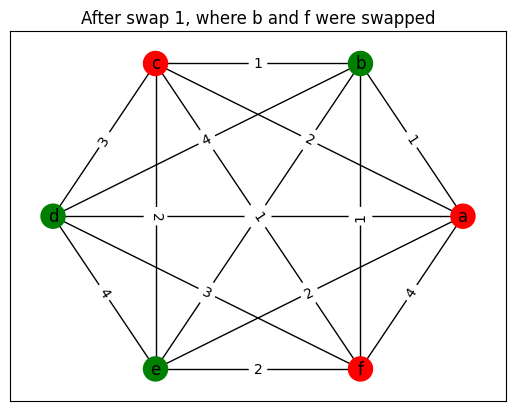

The wire cost of partitioning is 18


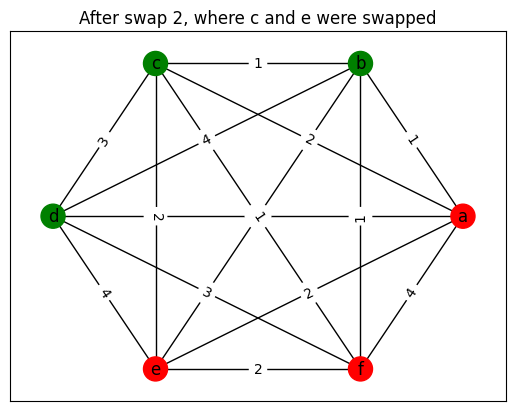

The wire cost of partitioning is 19


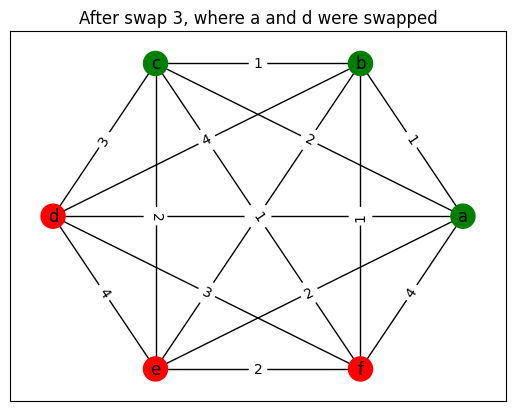

The wire cost of partitioning is 22


In [7]:
k = 0
while(k <= len(swaps) - 1):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    gv = GraphVisualizer()
    gv.addEdges(graph)
    gv.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The wire cost of partitioning is",graph.get_cost())
    k += 1

### As expected the cost of partitioning increases, if we don't stop at the maximal index